# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [325]:
import numpy as np
import pandas as pd

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [181]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

33.12163411176202

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [182]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

20.139004054494094

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [184]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [185]:
x = np.random.exponential(size = sample_size)
noise = np.random.uniform(size = sample_size, low = -1, high = 1)
y = f(x) + noise

In [186]:
from sklearn.tree import DecisionTreeRegressor


In [187]:
regressor = DecisionTreeRegressor()
x = x[:, np.newaxis]
regressor.fit(x,y)
y1 = regressor.predict(linspace[:, np.newaxis])


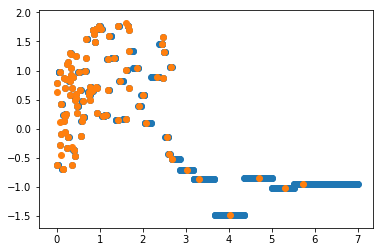

In [188]:
plt.scatter(linspace, y1)
plt.scatter(x, y)

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

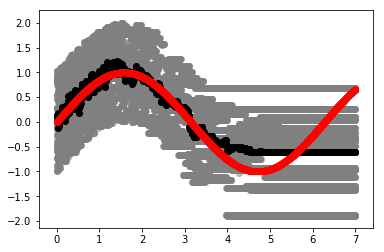

In [189]:
y_mean = np.zeros(linspace.size)
for i in range(samples_num):
    x = np.random.exponential(size = sample_size)
    noise = np.random.uniform(size = sample_size, low = -1, high = 1)
    y = f(x) + noise
    regressor = DecisionTreeRegressor()
    x = x[:, np.newaxis]
    regressor.fit(x,y)
    y1 = regressor.predict(linspace[:, np.newaxis])
    y_mean = y_mean + y1
    plt.scatter(linspace, y1, color="gray", alpha=0.5)

y_mean = y_mean / samples_num
plt.scatter(linspace, y_mean, color="black")
plt.scatter(linspace, f(linspace), color="red")
plt.show()

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

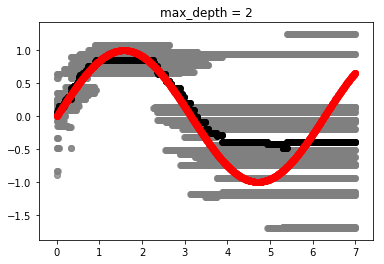

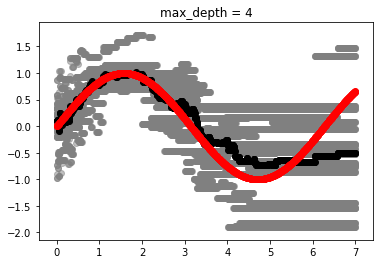

In [190]:
for md in [2,4]:
    y_mean = np.zeros(linspace.size)
    for i in range(samples_num):
        x = np.random.exponential(size = sample_size)
        noise = np.random.uniform(size = sample_size, low = -1, high = 1)
        y = f(x) + noise
        regressor = DecisionTreeRegressor(max_depth = md)
        x = x[:, np.newaxis]
        regressor.fit(x,y)
        y1 = regressor.predict(linspace[:, np.newaxis])
        y_mean = y_mean + y1
        plt.scatter(linspace, y1, color="gray", alpha=0.5)
    
    y_mean = y_mean / samples_num
    plt.scatter(linspace, y_mean, color="black")
    plt.scatter(linspace, f(linspace), color="red")
    plt.title('max_depth = '+str(md))
    plt.show()


__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

самое большое смещение при глубине = 2, а самое маленькое - в случае без ограничения на глубину дерева. Также из графиков видно, что чем меньше разброс, тем меньше смещение.

__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

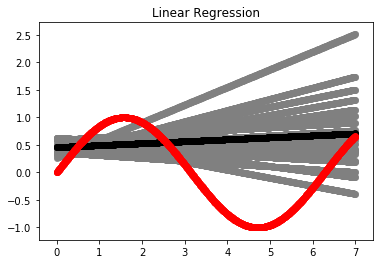

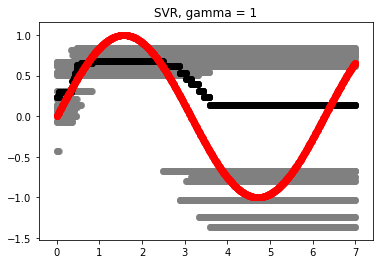

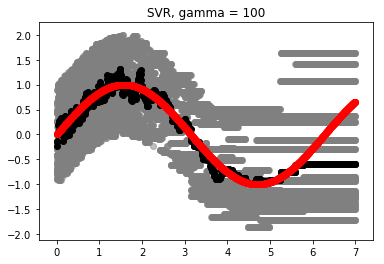

In [191]:
from sklearn.linear_model import LinearRegression

y_mean = np.zeros(linspace.size)
for i in range(samples_num):
    x = np.random.exponential(size = sample_size)
    noise = np.random.uniform(size = sample_size, low = -1, high = 1)
    y = f(x) + noise
    regressor = LinearRegression()
    x = x[:, np.newaxis]
    regressor.fit(x,y)
    y1 = regressor.predict(linspace[:, np.newaxis])
    y_mean = y_mean + y1
    plt.scatter(linspace, y1, color="gray", alpha=0.5)

y_mean = y_mean / samples_num
plt.scatter(linspace, y_mean, color="black")
plt.scatter(linspace, f(linspace), color="red")
plt.title('Linear Regression')
plt.show()

from sklearn.linear_model import LinearRegression

for md in [1, 100]:
    y_mean = np.zeros(linspace.size)
    for i in range(samples_num):
        x = np.random.exponential(size = sample_size)
        noise = np.random.uniform(size = sample_size, low = -1, high = 1)
        y = f(x) + noise
        regressor = DecisionTreeRegressor(max_depth = md)
        x = x[:, np.newaxis]
        regressor.fit(x,y)
        y1 = regressor.predict(linspace[:, np.newaxis])
        y_mean = y_mean + y1
        plt.scatter(linspace, y1, color="gray", alpha=0.5)
    
    y_mean = y_mean / samples_num
    plt.scatter(linspace, y_mean, color="black")
    plt.scatter(linspace, f(linspace), color="red")
    plt.title('SVR, gamma = '+str(md))
    plt.show()


линейная модель, как и ожидалось, выдала линейную аппроксимацию f c очень большим смещением, при SVM смещение тем меньше, чем меньше гамма.

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

In [324]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

In [193]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

In [178]:
mle = MultiColumnLabelEncoder()
le = LabelEncoder()
ohe = OneHotEncoder()

In [195]:
mushrooms = pd.read_csv("agaricus-lepiota.data")
y = le.fit_transform(mushrooms['p'])
X = mle.fit_transform(mushrooms.drop('p', axis = 1))

print("all real score = "+str(np.mean(cross_val_score(DecisionTreeClassifier(), X, y,
                                      scoring=make_scorer(accuracy_score), cv=10))))
print("all categorial score = "+str(np.mean(cross_val_score(DecisionTreeClassifier(), ohe.fit_transform(X), y,
                                      scoring=make_scorer(accuracy_score), cv=10))))
print("correct real and categorial score = "+str(np.mean(cross_val_score(DecisionTreeClassifier(), ohe.fit_transform(X), y,
                                      scoring=make_scorer(accuracy_score), cv=10))))


all real score = 0.958277103116
all categorial score = 0.968388683887
correct real and categorial score = 0.968388683887


In [196]:
tic_tac_toe = pd.read_csv("tic-tac-toe.data")
y = le.fit_transform(tic_tac_toe['positive'])
X = mle.fit_transform(tic_tac_toe.drop('positive', axis = 1))
print("all real score = "+str(np.mean(cross_val_score(DecisionTreeClassifier(), X, y,
                                      scoring=make_scorer(accuracy_score), cv=10))))
print("all categorial score = "+str(np.mean(cross_val_score(DecisionTreeClassifier(), ohe.fit_transform(X), y,
                                      scoring=make_scorer(accuracy_score), cv=10))))
print("correct real and categorial score = "+str(np.mean(cross_val_score(DecisionTreeClassifier(), ohe.fit_transform(X), y,
                                      scoring=make_scorer(accuracy_score), cv=10))))

all real score = 0.731373327003
all categorial score = 0.807940970338
correct real and categorial score = 0.818510693615


In [197]:
car = pd.read_csv("car.data")

def cl(a):
    if (a == 'unacc'):
        return 0
    elif (a == 'acc'):
        return 0
    elif (a == 'good'):
        return 1
    elif (a == 'vgood'):
        return 1

vcl = np.vectorize(cl)
    
y = le.fit_transform(vcl(np.array(car['unacc'])))
X = mle.fit_transform(car.drop('unacc', axis = 1))
print("all real score = "+str(np.mean(cross_val_score(DecisionTreeClassifier(), X, y,
                                      scoring=make_scorer(accuracy_score), cv=10))))
print("all categorial score = "+str(np.mean(cross_val_score(DecisionTreeClassifier(), ohe.fit_transform(X), y,
                                      scoring=make_scorer(accuracy_score), cv=10))))
print("correct real and categorial score = "+str(np.mean(cross_val_score(DecisionTreeClassifier(), X, y,
                                      scoring=make_scorer(accuracy_score), cv=10))))

all real score = 0.940373659789
all categorial score = 0.830403063692
correct real and categorial score = 0.940373659789


In [198]:
nursery = pd.read_csv("nursery.data")

def cl1(a):
    if (a == 'not_recom'):
        return 0
    elif (a == 'recommend'):
        return 0
    elif (a == 'very_recom'):
        return 1
    elif (a == 'priority'):
        return 1
    elif (a == 'spec_prior'):
        return 1

vcl1 = np.vectorize(cl1)

y = le.fit_transform(vcl1(np.array(nursery['recommend'])))
X = mle.fit_transform(nursery.drop('recommend', axis = 1))
print("all real score = "+str(np.mean(cross_val_score(DecisionTreeClassifier(), X, y,
                                      scoring=make_scorer(accuracy_score), cv=10))))
print("all categorial score = "+str(np.mean(cross_val_score(DecisionTreeClassifier(), ohe.fit_transform(X), y,
                                      scoring=make_scorer(accuracy_score), cv=10))))
print("correct real and categorial score = "+str(np.mean(cross_val_score(DecisionTreeClassifier(), X, y,
                                      scoring=make_scorer(accuracy_score), cv=10))))

all real score = 0.999845738504
all categorial score = 0.999845738504
correct real and categorial score = 0.999845738504


__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

на разных датасетах алгоритмы ранжируются по-разному, т.к. из-за кодирования вешественных признаков категориальным образом приводит к увеличению количества признаков сверх меры => в адекватном решающем дереве должно быть очень много условий (чтобы задать условие x>2, надо написать i_3>0.5 and i_4>0.5 and etc.), плэтому, если ветвлений в дереве мало, то алгоритм будет недообучен, а если ветвлений много, то очень вероятно переобучение. Кодирование категориальных признаков вещественными тоже вредно, т.к. вместо того, чтобы задать условие (машина красная > 0.5), надо задавать (цвет >5.5 and цвет <6.5), поэтому тоже возникает необходимость увеличения количества ветвлений => перебучение.

Если один и тот же алгоритм запустить 2 раза, то результаты будут немного различаться, т.к. в самом алгоритме используется генератор случайных чисел. Поэтому усреднение нескольких деревьев может убрать этот шум.

### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [199]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [200]:
df = pd.read_csv("winequality-red.csv", sep = ';')
y = np.array(df['quality'])
X = np.array(df.drop('quality', axis = 1))
print("DecisionTreeClassifier score = "+str(np.mean(cross_val_score(DecisionTreeClassifier(), X, y,
                                      scoring=make_scorer(accuracy_score), cv=3))))
print("BaggingClassifier score = "+str(np.mean(cross_val_score(BaggingClassifier(n_estimators = 100), X, y,
                                      scoring=make_scorer(accuracy_score), cv=3))))
print("BaggingClassifier score (max_samples=0.5) = "+str(np.mean(cross_val_score(BaggingClassifier(n_estimators = 100, max_samples = 0.5), X, y,
                                      scoring=make_scorer(accuracy_score), cv=3))))
print("RandomForestClassifier score = "+str(np.mean(cross_val_score(RandomForestClassifier(n_estimators = 100, max_depth = 4), X, y,
                                      scoring=make_scorer(accuracy_score), cv=3))))

DecisionTreeClassifier score = 0.441549042231
BaggingClassifier score = 0.562927343961
BaggingClassifier score (max_samples=0.5) = 0.574824009272
RandomForestClassifier score = 0.574175116026


#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

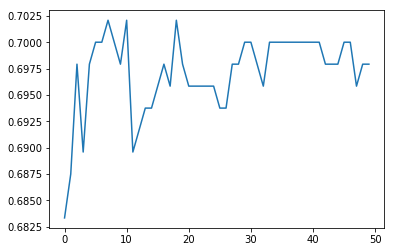

In [194]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("winequality-red.csv", sep = ';')
y = np.array(df['quality'])
X = np.array(df.drop('quality', axis = 1))
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.3) 

regressor = RandomForestClassifier(warm_start=True)

ac_arr = []
for i1 in range(50):
    i = i1*100+100
    regressor.set_params(n_estimators = i)
    regressor.fit(train_X, train_Y)
    ac_arr.append(accuracy_score(test_Y,regressor.predict(test_X)))

plt.plot(ac_arr)

нет, лес не  переобучается с увеличением числа деревьев

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

Using TensorFlow backend.


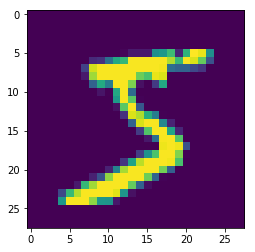

In [2]:
from keras.datasets import mnist
import keras as keras
(x_train, y_train), (x_test, y_test) = mnist.load_data()
plt.imshow(x_train[0])

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

In [327]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Flatten, Dense

In [328]:
ohe = OneHotEncoder()

x_train = x_train.reshape(60000,784)
x_test = x_test.reshape(10000,784)

y_test = y_test.astype("float32")
y_train = y_train.astype("float32")

y_train = keras.utils.to_categorical(y_train, num_classes=None)
y_test = keras.utils.to_categorical(y_test, num_classes=None)

In [329]:
model = Sequential()
model.add(Dense(output_dim=100, input_dim = 784, activation = 'relu'))
model.add(Dense(output_dim=100, input_dim = 100, activation = 'relu'))
model.add(Dense(output_dim=10, input_dim = 100, activation = 'softmax'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

C:\Users\agapo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=784, activation="relu", units=100)`
  
C:\Users\agapo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, activation="relu", units=100)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\agapo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=100, activation="softmax", units=10)`
  after removing the cwd from sys.path.


In [330]:
model.fit(x=x_train, y=y_train)

Epoch 1/10
60000/60000 [==============================] - 10s - loss: 1.1713 - acc: 0.9237    
Epoch 2/10
60000/60000 [==============================] - 10s - loss: 0.6092 - acc: 0.9604    
Epoch 3/10
60000/60000 [==============================] - 9s - loss: 0.5641 - acc: 0.9636     
Epoch 4/10
60000/60000 [==============================] - 9s - loss: 0.5620 - acc: 0.9640     
Epoch 5/10
60000/60000 [==============================] - 9s - loss: 0.3489 - acc: 0.9775     
Epoch 6/10
60000/60000 [==============================] - 10s - loss: 0.3218 - acc: 0.9793    
Epoch 7/10
60000/60000 [==============================] - 11s - loss: 0.3043 - acc: 0.9806    
Epoch 8/10
60000/60000 [==============================] - 9s - loss: 0.3277 - acc: 0.9791     
Epoch 9/10
60000/60000 [==============================] - 9s - loss: 0.2958 - acc: 0.9812     
Epoch 10/10
60000/60000 [==============================] - 9s - loss: 0.3020 - acc: 0.9809     


In [331]:
y_pred = model.predict(x_test)
print('accuracy = '+str((y_pred*y_test).sum()/y_test.shape[0]))

accuracy = 0.915416938832


__10 (2 балл)__
Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке. 

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

In [332]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

ohe = OneHotEncoder()

x_train = x_train[:,:,:,np.newaxis]
x_test = x_test[:,:,:,np.newaxis]

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

y_test = y_test.astype(int)
y_train = y_train.astype(int)

y_train = keras.utils.to_categorical(y_train, num_classes=None)
y_test = keras.utils.to_categorical(y_test, num_classes=None)

In [334]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Flatten, Dense, MaxPooling2D, Dropout

model = Sequential()


model.add(ZeroPadding2D((1,1),input_shape=(28, 28, 1)))
model.add(Convolution2D(filters=70, kernel_size=(5,5), data_format='channels_last', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(filters=80, kernel_size=(5,5), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(500, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))

model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_70 (ZeroPaddi (None, 30, 30, 1)         0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 26, 26, 70)        1820      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 13, 13, 70)        0         
_________________________________________________________________
zero_padding2d_71 (ZeroPaddi (None, 15, 15, 70)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 11, 11, 80)        140080    
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 5, 5, 80)          0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 2000)              0         
__________

In [335]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [336]:
model.fit(x=x_train, y=y_train, nb_epoch = 10)

C:\Users\agapo\Anaconda3\lib\site-packages\keras\models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/10
60000/60000 [==============================] - 481s - loss: 0.0190 - acc: 0.9935   
Epoch 2/10
60000/60000 [==============================] - 470s - loss: 0.0076 - acc: 0.9976   
Epoch 3/10
60000/60000 [==============================] - 478s - loss: 0.0055 - acc: 0.9983   
Epoch 4/10
60000/60000 [==============================] - 493s - loss: 0.0042 - acc: 0.9986   
Epoch 5/10
60000/60000 [==============================] - 486s - loss: 0.0035 - acc: 0.9989   
Epoch 6/10
60000/60000 [==============================] - 477s - loss: 0.0027 - acc: 0.9991   
Epoch 7/10
60000/60000 [==============================] - 473s - loss: 0.0025 - acc: 0.9992   
Epoch 8/10
60000/60000 [==============================] - 483s - loss: 0.0023 - acc: 0.9993   
Epoch 9/10
60000/60000 [==============================] - 488s - loss: 0.0019 - acc: 0.9995   
Epoch 10/10
60000/60000 [==============================] - 532s - loss: 0.0017 - acc: 0.9995   


In [337]:
y_pred = model.predict(x_test)
print('accuracy = '+str((y_pred*y_test).sum()/y_test.shape[0]))

accuracy = 0.990824109336


__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 

In [338]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

ohe = OneHotEncoder()

x_train = x_train[:,:,:,np.newaxis]
x_test = x_test[:,:,:,np.newaxis]

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

y_test = y_test.astype(int)
y_train = y_train.astype(int)

y_train = keras.utils.to_categorical(y_train, num_classes=None)
y_test = keras.utils.to_categorical(y_test, num_classes=None)

In [340]:
from keras.layers import Dropout

model = Sequential()


model.add(ZeroPadding2D((1,1),input_shape=(28, 28, 1)))
model.add(Convolution2D(filters=70, kernel_size=(5,5), data_format='channels_last', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(filters=80, kernel_size=(5,5), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(500, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation = 'relu'))

model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_73 (ZeroPaddi (None, 30, 30, 1)         0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 26, 26, 70)        1820      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 13, 13, 70)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 70)        0         
_________________________________________________________________
zero_padding2d_74 (ZeroPaddi (None, 15, 15, 70)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 11, 11, 80)        140080    
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 5, 5, 80)          0         
__________

In [341]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [342]:
model.fit(x=x_train, y=y_train, nb_epoch = 10)

C:\Users\agapo\Anaconda3\lib\site-packages\keras\models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/10
60000/60000 [==============================] - 575s - loss: 0.0360 - acc: 0.9876   
Epoch 2/10
60000/60000 [==============================] - 514s - loss: 0.0167 - acc: 0.9946   
Epoch 3/10
60000/60000 [==============================] - 517s - loss: 0.0136 - acc: 0.9956   
Epoch 4/10
60000/60000 [==============================] - 504s - loss: 0.0127 - acc: 0.9961   
Epoch 5/10
60000/60000 [==============================] - 484s - loss: 0.0114 - acc: 0.9965   
Epoch 6/10
60000/60000 [==============================] - 483s - loss: 0.0110 - acc: 0.9965   
Epoch 7/10
60000/60000 [==============================] - 504s - loss: 0.0098 - acc: 0.9970   
Epoch 8/10
60000/60000 [==============================] - 500s - loss: 0.0100 - acc: 0.9969   
Epoch 9/10
60000/60000 [==============================] - 497s - loss: 0.0090 - acc: 0.9972   
Epoch 10/10
60000/60000 [==============================] - 499s - loss: 0.0094 - acc: 0.9971   


In [343]:
y_pred = model.predict(x_test)
print('accuracy = '+str((y_pred*y_test).sum()/y_test.shape[0]))

accuracy = 0.987600993108


как видно, добавление dropout слоёв привело к понижению accuracy и на обучающей выборке, и на тестовой. Время обучения увеличилось.